In [212]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import pickle
from sklearn.preprocessing import MinMaxScaler


In [213]:
df = pd.read_csv('../data/madrid_idealista.csv') 

First, we gonna understand the dataset, searching correlation between columns and their distributions

In [214]:
# general information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Address         517 non-null    object 
 1   Price           517 non-null    float64
 2   Rooms           430 non-null    float64
 3   Squared_meters  517 non-null    int64  
 4   Floor           517 non-null    int64  
 5   Link            517 non-null    object 
 6   Summary         517 non-null    object 
 7   Distric         517 non-null    object 
 8   Type            517 non-null    object 
 9   Pool            517 non-null    bool   
 10  Furniture       517 non-null    bool   
 11  Exterior        517 non-null    bool   
 12  Elevator        517 non-null    bool   
dtypes: bool(4), float64(2), int64(2), object(5)
memory usage: 38.5+ KB


Column: Price


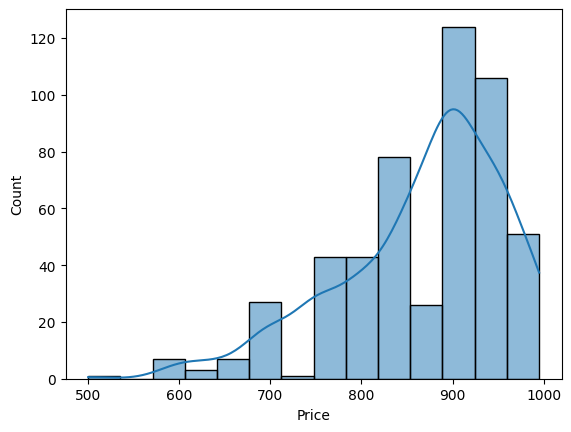

Column: Rooms


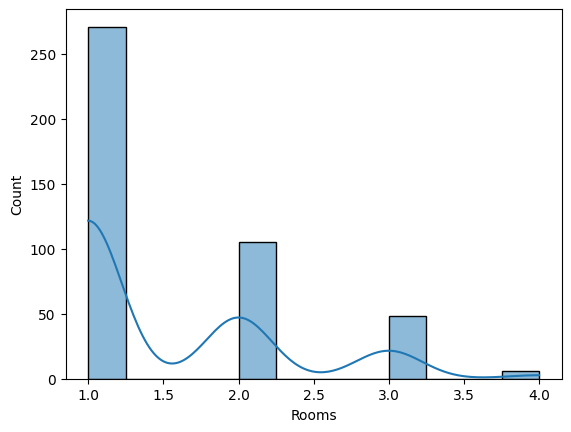

Column: Squared_meters


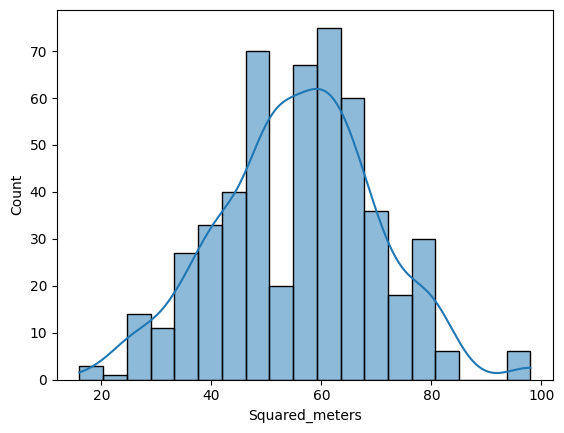

Column: Floor


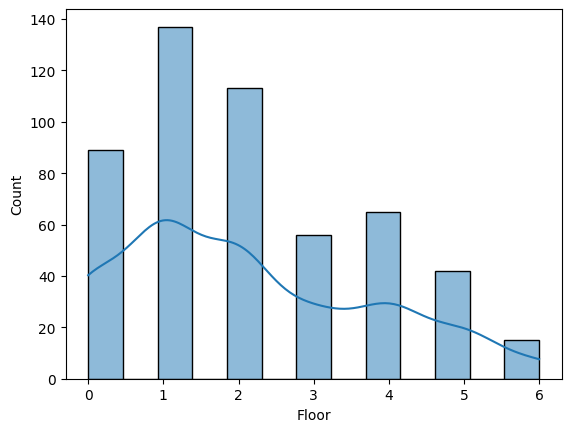

In [215]:
# distribution of numerical columns
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    print(f"Column: {col}")
    sns.histplot(df[col], kde=True)  
    plt.show()

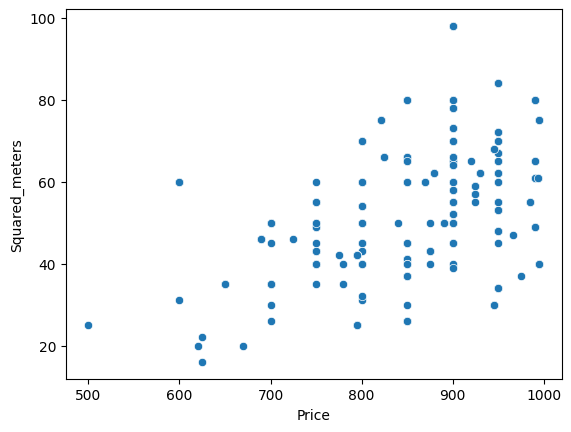

<Axes: >

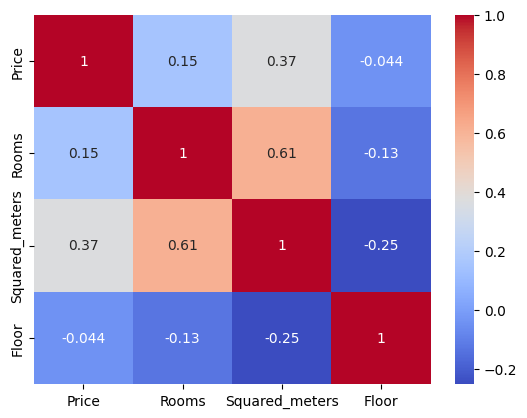

In [216]:
# scatter plot of Price vs. Squared_meters
sns.scatterplot(x='Price', y='Squared_meters', data=df)
plt.show()
# heatmap of correlations
sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), annot=True, cmap='coolwarm')


Now, we are going to clean and prepare the dataset

In [217]:
# the only column with missing values is 'Rooms', so we
# will fill it with the mean of the column that are more similar to it

important_cols = ['Price', 'Squared_meters', 'Distric', 'Type']
for null_line in df[df['Rooms'].isnull()].index:
    filter = df[important_cols] == df.loc[null_line, important_cols]
    similar_rows = filter[filter.sum(axis=1) >= 2].index
    value = df.loc[similar_rows, 'Rooms'].mean(skipna=True)
    if value is None or pd.isna(value):
        print(f"No similar rows found for index {null_line}.")
        df.loc[null_line, 'Rooms'] = df.loc[:, 'Rooms'].mean(skipna=True)
    else:
        df.loc[null_line, 'Rooms'] = value

No similar rows found for index 24.


In [218]:
# drop useless columns
drop_cols = ['Link', 'Address', 'Summary']
df.drop(columns=drop_cols, inplace=True)

In [219]:
# codification of categorical columns
df = pd.get_dummies(df, columns=['Distric', 'Type'], drop_first=True)

In [222]:
print(numerical_cols)

Index(['Rooms', 'Squared_meters', 'Floor', 'Pool', 'Furniture', 'Exterior',
       'Elevator', 'Distric_Chueca', 'Distric_La Latina', 'Distric_Lavapies',
       'Distric_Malasaña', 'Distric_Moncloa', 'Type_Duplex', 'Type_Flat',
       'Type_Studio'],
      dtype='object')


In [220]:
# normalization of numerical columuns
scaler = MinMaxScaler()
y = df['Price']
df.drop(columns=['Price'], inplace=True)
numerical_cols = df.select_dtypes(include=['float64', 'int64', 'bool']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# save the scaler
with open('./scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [221]:
# final dataset
df

,Rooms,Squared_meters,Floor,Pool,Furniture,Exterior,Elevator,Distric_Chueca,Distric_La Latina,Distric_Lavapies,Distric_Malasaña,Distric_Moncloa,Type_Duplex,Type_Flat,Type_Studio
0,0.142857,0.475610,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.015873,0.414634,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.194004,0.695122,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.304794,0.304878,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.164382,0.317073,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.000000,0.414634,0.500000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
513,0.000000,0.414634,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
514,0.333333,0.780488,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
515,0.333333,0.719512,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


Visualization with dimensionality reduction

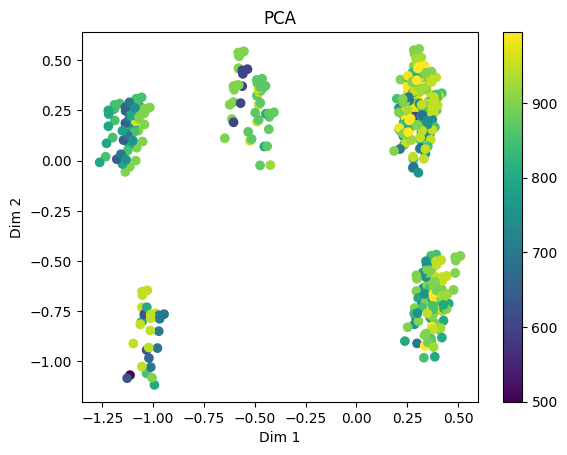

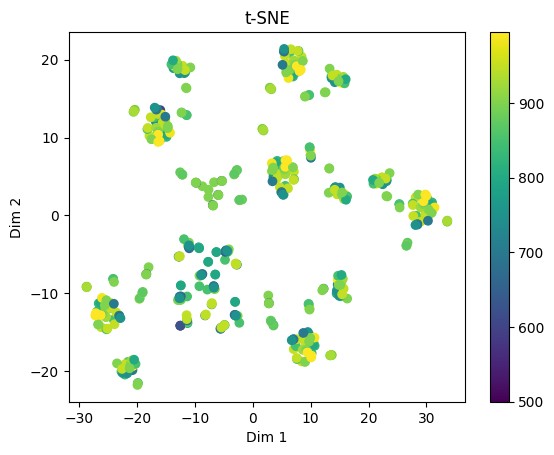

In [223]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title("PCA")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar()
plt.show()

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title("t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.colorbar()
plt.show()


Search the best model with sklearn

In [228]:
X_test.columns

Index(['Rooms', 'Squared_meters', 'Floor', 'Pool', 'Furniture', 'Exterior',
       'Elevator', 'Distric_Chueca', 'Distric_La Latina', 'Distric_Lavapies',
       'Distric_Malasaña', 'Distric_Moncloa', 'Type_Duplex', 'Type_Flat',
       'Type_Studio'],
      dtype='object')

In [224]:
X = df
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)

svc = SVR()
svc.fit(X_train, y_train)
svm_prediction = svc.predict(X_test)

gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_prediction = gb.predict(X_test)


print("Random Forest Regression Results:")
print("MAE:", mean_absolute_error(y_test, rf_prediction))
print("RMSE:", mean_squared_error(y_test, rf_prediction))
print("R²:", r2_score(y_test, rf_prediction))

print("Support Vector Regression Results:")
print("MAE:", mean_absolute_error(y_test, svm_prediction))
print("RMSE:", mean_squared_error(y_test, svm_prediction))
print("R²:", r2_score(y_test, svm_prediction))

print("Gradient Boosting Regression Results:")
print("MAE:", mean_absolute_error(y_test, gb_prediction))
print("RMSE:", mean_squared_error(y_test, gb_prediction))
print("R²:", r2_score(y_test, gb_prediction))


Random Forest Regression Results:
MAE: 15.705452991452988
RMSE: 1562.6125443848234
R²: 0.7958311698625447
Support Vector Regression Results:
MAE: 64.94552072919679
RMSE: 7953.622899884118
R²: -0.039209552399384284
Gradient Boosting Regression Results:
MAE: 35.275290620048075
RMSE: 2758.602897794154
R²: 0.6395646966483568


Finally, we save the best model

In [225]:
with open("model.pkl", "wb") as f:
    pickle.dump(rf, f)

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rooms              517 non-null    float64
 1   Squared_meters     517 non-null    float64
 2   Floor              517 non-null    float64
 3   Pool               517 non-null    float64
 4   Furniture          517 non-null    float64
 5   Exterior           517 non-null    float64
 6   Elevator           517 non-null    float64
 7   Distric_Chueca     517 non-null    float64
 8   Distric_La Latina  517 non-null    float64
 9   Distric_Lavapies   517 non-null    float64
 10  Distric_Malasaña   517 non-null    float64
 11  Distric_Moncloa    517 non-null    float64
 12  Type_Duplex        517 non-null    float64
 13  Type_Flat          517 non-null    float64
 14  Type_Studio        517 non-null    float64
dtypes: float64(15)
memory usage: 60.7 KB
